In [33]:
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score,
    f1_score, precision_score, recall_score,
    classification_report, accuracy_score,
    make_scorer
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle


In [9]:
# Upload CSV file
uploaded = files.upload()

# Read CSV into DataFrame (replace with your actual filename)
df = pd.read_csv('diabetes_df.csv')

Saving diabetes_df.csv to diabetes_df (1).csv


**5. Split Data** : 70% for train data, 15% for validation data and 15% for test data.

In [10]:
y = df['readmitted']
X = df.drop(['readmitted'], axis=1)

In [11]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)

  **6. Scale features**

In [12]:
sc_X = StandardScaler()

# Fit on train, apply same transform to val & test
Xsc_train = sc_X.fit_transform(X_train)
Xsc_val   = sc_X.transform(X_val)
Xsc_test  = sc_X.transform(X_test)

# ML Models:

*   Logistic Regression
*   Random Forest
*   SVM
*   XGBoost (multi-class)

In [19]:
# Logistic Regression
lr = LogisticRegression(max_iter=5000, random_state=120, class_weight="balanced", penalty='l1', solver='saga' ,C=0.1)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_val)

# Random Forest
rfm = RandomForestClassifier(random_state=120, n_estimators=500, class_weight="balanced", max_depth=10, min_samples_split=5, min_samples_leaf=2)
rfm.fit(X_train, y_train)
rfm_pred = rfm.predict(X_val)

# Train LinearSVC with L1 penalty
linear_svc_l1 = LinearSVC(penalty='l1', dual=False, C=0.1, max_iter=100000, random_state=120)
linear_svc_l1.fit(X_train, y_train)
svm_pred = linear_svc_l1.predict(X_val)

# XGBoost
xgbm = xgb.XGBClassifier(objective="multi:softprob", num_class=3, use_label_encoder=False, eval_metric="mlogloss", random_state=120)
xgbm.fit(X_train, y_train)
xgbm_pred = xgbm.predict(X_val)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


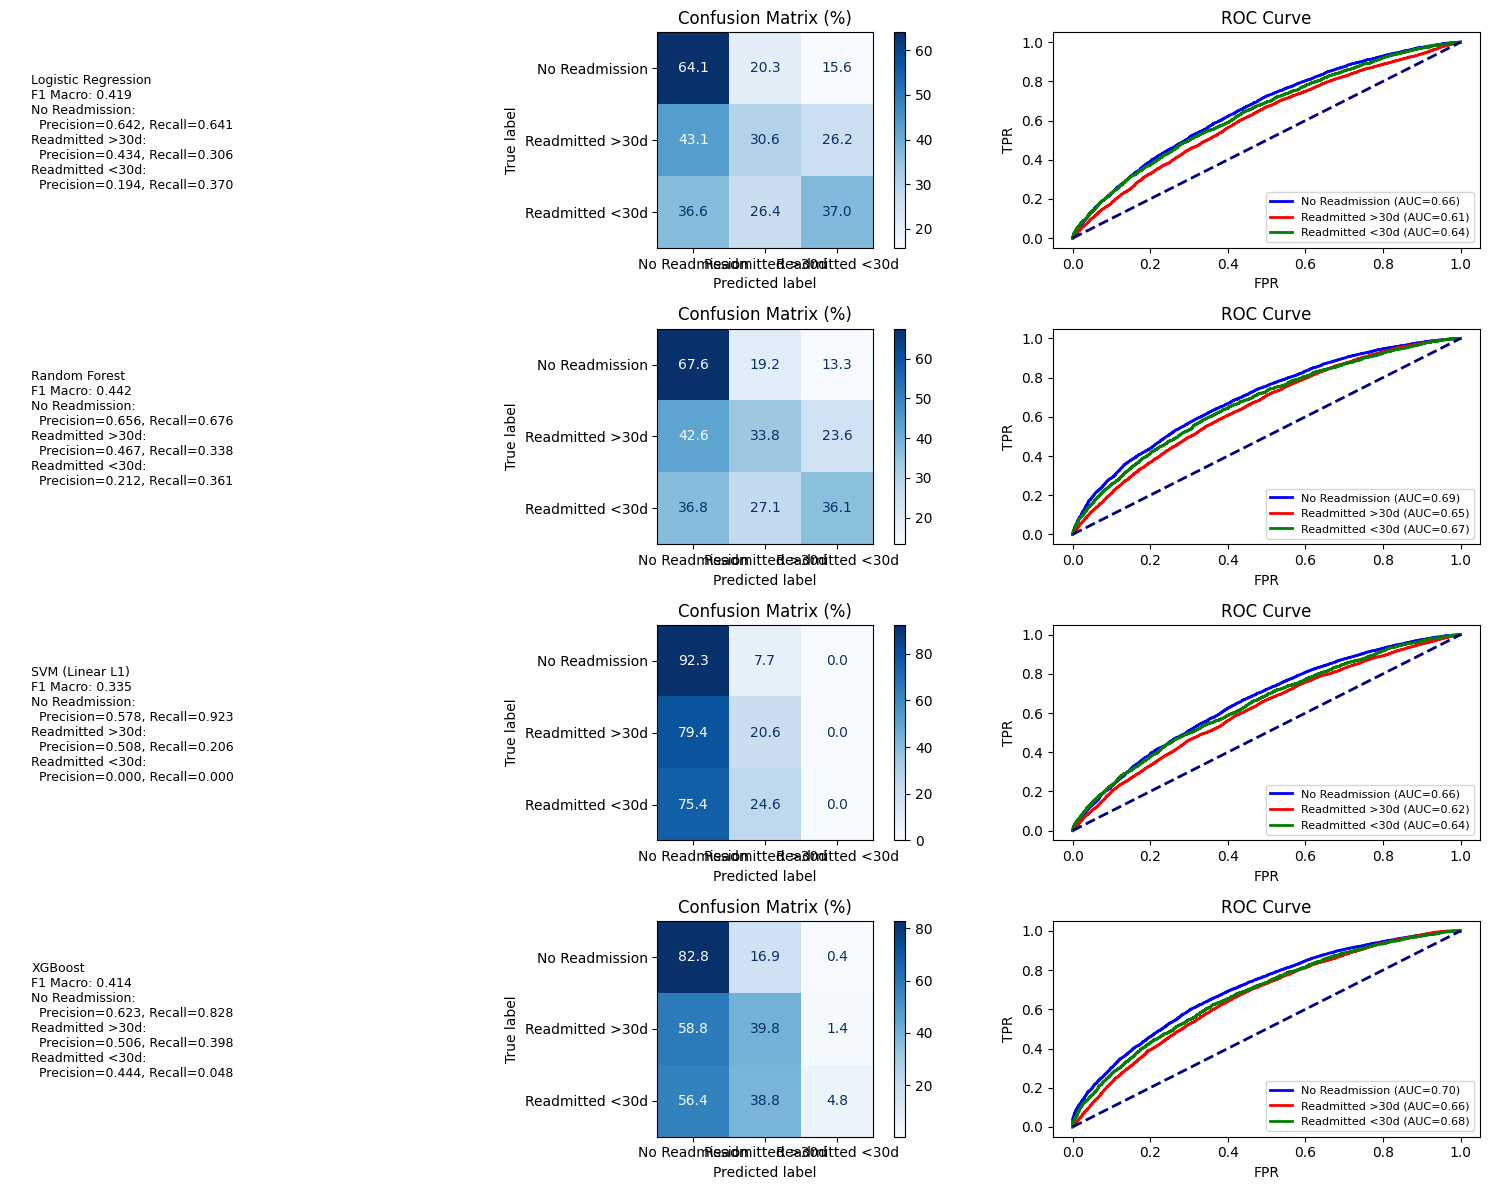

In [29]:

# Build models dict (replace your old svm with this)
models = {
    'Logistic Regression': (lr, lr_pred),
    'Random Forest': (rfm, rfm_pred),
    'SVM (Linear L1)': (linear_svc_l1, svm_pred),
    'XGBoost': (xgbm, xgbm_pred)
}

# Classes & labels
classes = [0, 1, 2]
class_labels = ['No Readmission','Readmitted >30d','Readmitted <30d']
colors = ['b','r','g']

# Binarize true labels
y_val_bin = label_binarize(y_val, classes=classes)

# Create figure: rows = models, cols = (metrics, confusion, ROC)
fig, axes = plt.subplots(len(models), 3, figsize=(15, 12))

for row_idx, (name, (model, y_pred)) in enumerate(models.items()):
    # F1 / Precision / Recall
    f1 = f1_score(y_val, y_pred, average='macro')
    precision_list = [precision_score(y_val, y_pred, labels=[i], average='macro') for i in classes]
    recall_list = [recall_score(y_val, y_pred, labels=[i], average='macro') for i in classes]

    axes[row_idx, 0].axis('off')
    metrics_text = f"{name}\nF1 Macro: {f1:.3f}\n"
    for lbl, p, r in zip(class_labels, precision_list, recall_list):
        metrics_text += f"{lbl}:\n  Precision={p:.3f}, Recall={r:.3f}\n"
    axes[row_idx, 0].text(0.05, 0.5, metrics_text, fontsize=9, va='center')

    # Confusion Matrix (%)
    cm = confusion_matrix(y_val, y_pred, labels=classes)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=class_labels)
    disp.plot(cmap='Blues', ax=axes[row_idx, 1], values_format='.1f')
    axes[row_idx, 1].set_title('Confusion Matrix (%)')

    # ROC curve
    ax_roc = axes[row_idx, 2]
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_val)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_val)
    else:
        y_score = None

    if y_score is not None:
        # Ensure 2D output for ROC plotting
        if len(y_score.shape) == 1:
            y_score = np.column_stack([-y_score, y_score])

        for i, color, lbl in zip(classes, colors, class_labels):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            ax_roc.plot(fpr, tpr, color=color, lw=2, label=f'{lbl} (AUC={roc_auc:.2f})')

        ax_roc.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
        ax_roc.set_xlabel('FPR')
        ax_roc.set_ylabel('TPR')
        ax_roc.set_title('ROC Curve')
        ax_roc.legend(fontsize=8, loc='lower right')
    else:
        ax_roc.text(0.5, 0.5, "No scores\nROC skipped", ha='center', va='center')
        ax_roc.axis('off')

plt.tight_layout()
plt.show()

Model Performance Comparison:

                 Model  Accuracy  Precision  Recall  F1 Score    AUC
0  Logistic Regression     0.493      0.423   0.439     0.419  0.638
1        Random Forest     0.522      0.445   0.458     0.442  0.670
2      SVM (Linear L1)     0.568      0.362   0.376     0.335    NaN
3              XGBoost     0.589      0.524   0.424     0.414  0.682


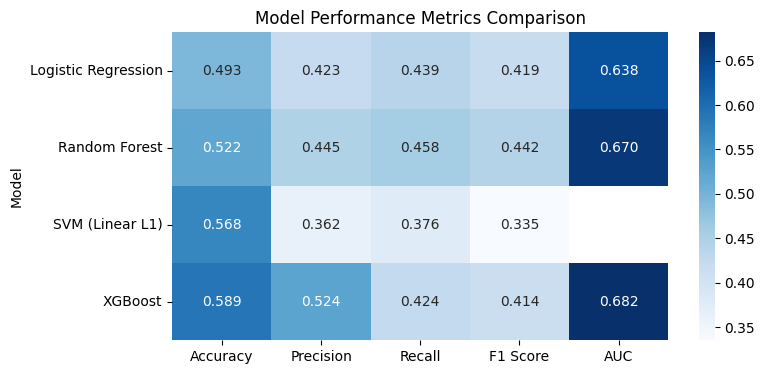

In [31]:
results = []

for name, (model, y_pred) in models.items():
    # Base metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_val, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_val, y_pred, average="macro", zero_division=0)

    # AUC (if available)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_val)
        auc_score = roc_auc_score(y_val_bin, y_score, average="macro", multi_class="ovr")
    else:
        auc_score = np.nan  # skip if no probability output

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc_score
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display nicely
print("Model Performance Comparison:\n")
print(results_df.round(3))

# Highlight best model per metric
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.heatmap(results_df.set_index("Model").round(3), annot=True, cmap="Blues", fmt=".3f")
plt.title("Model Performance Metrics Comparison")
plt.show()

I choose **XGBoost**, because

*   Best overall predictive performance among models (accuracy, precision, AUC)
*   Handles non-linear relationships and complex feature interactions
*   Robust to overfitting and works well with heterogeneous features

## Hyperparameter tuning for XGBoost

  **1. Select parameters to tune:**
*   n_estimators (number of trees)
*   max_depth (depth of each tree)
*   learning_rate (shrinkage factor)
*   subsample (fraction of samples per tree)
*   colsample_bytree (fraction of features per tree)
*   gamma (minimum loss reduction for a split)

**2. Tunning Method:**  RandomizedSearchCV for faster search on large grids

  **3. Evaluation metric:** f1_macro and roc_auc_ovr.

In [34]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

# Initialize XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=120
)

# Define multiple scorers
scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'roc_auc_ovr': 'roc_auc_ovr'  # built-in scorer for multi-class ROC-AUC
}

# Randomized Search
rand_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring=scoring,
    refit='f1_macro',   # choose primary metric for refit
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=120
)

# Fit
rand_search.fit(X_train, y_train)

# Best model
best_xgb = rand_search.best_estimator_
print("Best Parameters:", rand_search.best_params_)
print("Best F1 Score:", rand_search.best_score_)

# Optionally check ROC-AUC on validation set
y_val_prob = best_xgb.predict_proba(X_val)
y_val_bin = label_binarize(y_val, classes=[0,1,2])
roc_auc_val = roc_auc_score(y_val_bin, y_val_prob, multi_class='ovr')
print("Validation ROC-AUC (OvR):", roc_auc_val)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:17:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best F1 Score: 0.40909865999370104
Validation ROC-AUC (OvR): 0.6868938416494658


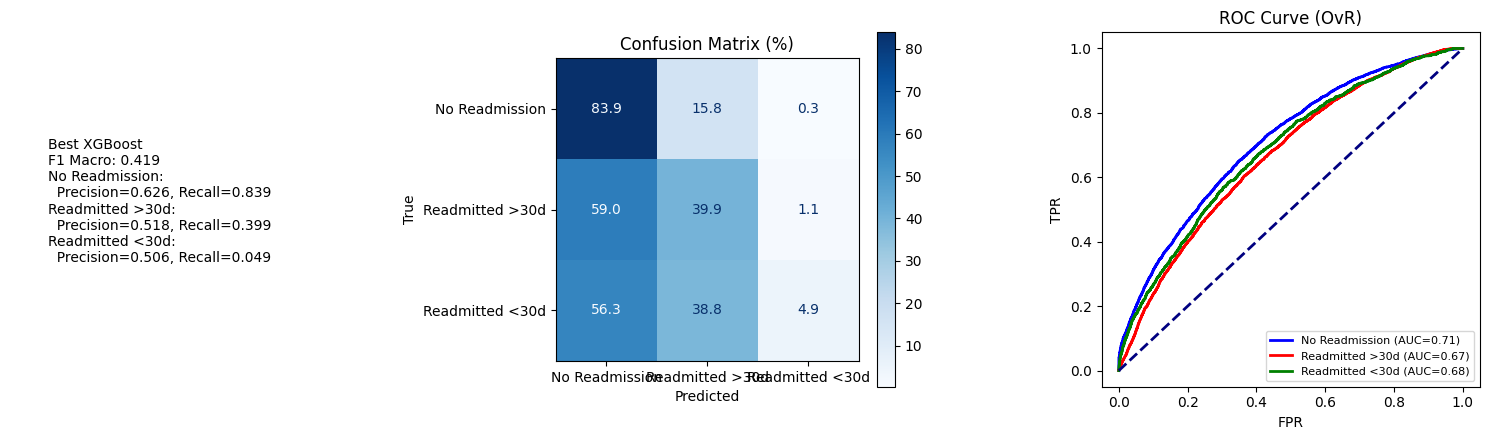

In [35]:
# Classes and labels
classes = [0, 1, 2]
class_labels = ['No Readmission', 'Readmitted >30d', 'Readmitted <30d']
colors = ['b', 'r', 'g']

# Predictions
y_val_pred = best_xgb.predict(X_val)
y_val_prob = best_xgb.predict_proba(X_val)
y_val_bin = label_binarize(y_val, classes=classes)

# F1, precision, recall
f1 = f1_score(y_val, y_val_pred, average='macro')
precision_list = [precision_score(y_val, y_val_pred, labels=[i], average='macro') for i in classes]
recall_list = [recall_score(y_val, y_val_pred, labels=[i], average='macro') for i in classes]

# Create figure: 1 row x 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

# Text: F1, precision, recall
axes[0].axis('off')
metrics_text = f"Best XGBoost\nF1 Macro: {f1:.3f}\n"
for lbl, p, r in zip(class_labels, precision_list, recall_list):
    metrics_text += f"{lbl}:\n  Precision={p:.3f}, Recall={r:.3f}\n"
axes[0].text(0.1, 0.5, metrics_text, fontsize=10, va='center')

# Confusion Matrix (%)
cm = confusion_matrix(y_val, y_val_pred, labels=classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=class_labels)
disp.plot(cmap='Blues', ax=axes[1], values_format='.1f')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Confusion Matrix (%)')

# ROC Curve
ax_roc = axes[2]
for i, color, lbl in zip(classes, colors, class_labels):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_val_prob[:, i])
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, color=color, lw=2, label=f'{lbl} (AUC={roc_auc:.2f})')
ax_roc.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
ax_roc.set_xlabel('FPR')
ax_roc.set_ylabel('TPR')
ax_roc.set_title('ROC Curve (OvR)')
ax_roc.legend(fontsize=8, loc='lower right')

plt.tight_layout()
plt.show()